In [1]:

from pathlib import Path
import pandas as pd
import seaborn as sns
from typing import List
import numpy as np

sns.set_style("whitegrid")
sns.set_context("talk", font_scale=1)
sns.set_palette("colorblind")

ll_o = Path("module/latest-ll-o")
bu_o = Path("module/latest-bu-o")
ll_c = Path("module/latest-ll-c")
bu_c = Path("module/latest-bu-c")


def read_orders(dir: str, orders: List[int]) -> pd.DataFrame:
    data = []
    for o in orders:
        d = pd.read_csv(f"{dir}/out_{o}.csv")
        d["order"] = o
        data.append(d)
    data = pd.concat(data)
    data["cores"] = data["x"]
    data["alloc"] = data["get_avg"]
    data["free"] = data["put_avg"]
    return data[["order", "cores", "iteration", "alloc", "free"]]


def read_allocs(ll: Path, bu: Path, bench: str, orders: List[int]) -> pd.DataFrame:
    ll_d = read_orders(ll / bench, orders)
    ll_d["Allocator"] = "LLFree"
    bu_d = read_orders(bu / bench, orders)
    bu_d["Allocator"] = "Buddy"
    return pd.concat([ll_d, bu_d])


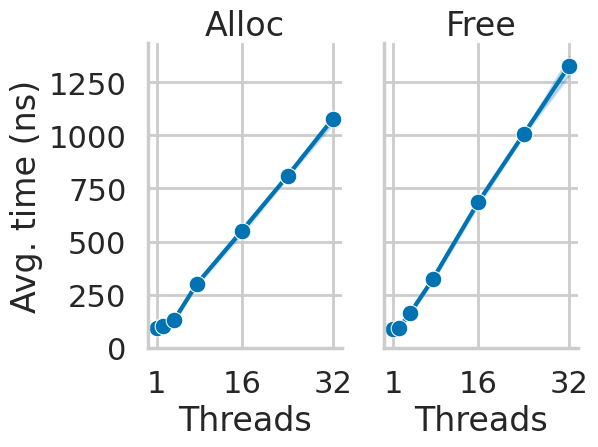

In [3]:
pgd = pd.read_csv(bu_c / "bulk" / "out_0.csv")
pgd["alloc"] = "Buddy"
pgd["cores"] = pgd["x"]
pgd["Alloc"] = pgd["get_avg"]
pgd["Free"] = pgd["put_avg"]
pgd = pgd[["cores", "alloc", "Alloc", "Free"]]
pgd = pgd.melt(
    id_vars=["cores", "alloc"],
    value_vars=["Alloc", "Free"], value_name="time")

with sns.plotting_context("poster"):
    g = sns.relplot(data=pgd, kind="line", x="cores", y="time", legend=False,
                    col="variable", style="alloc", hue="alloc", markers=True,
                    aspect=0.64)
    g.set(xticks=[1, 16, 32])
    g.set(ylim=(0, None))
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Threads")
    g.set_titles("{col_name}")
    g.savefig("out/buddy_threads.pdf")


# Order Scaling

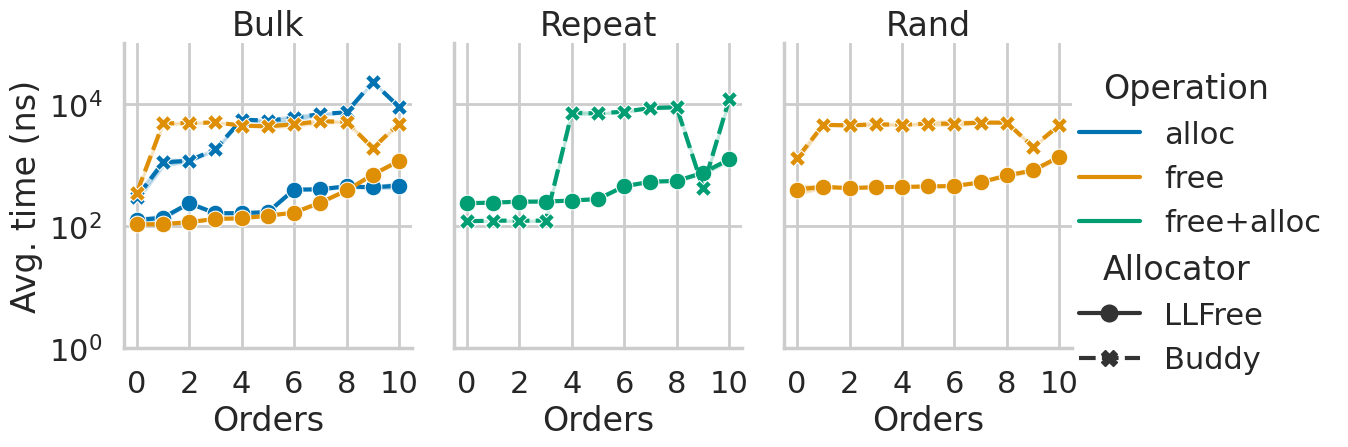

In [15]:

data_o_b = read_allocs(ll_o, bu_o, "bulk", list(range(11)))
data_o_b["bench"] = "Bulk"
data_o_r = read_allocs(ll_o, bu_o, "repeat", list(range(11)))
data_o_r["bench"] = "Repeat"
data_o_r["free+alloc"] = data_o_r["alloc"]
data_o_r["alloc"] = np.nan
data_o_r["free"] = np.nan
data_o_a = read_allocs(ll_o, bu_o, "rand", list(range(11)))
data_o_a["bench"] = "Rand"
data_o_a["alloc"] = np.nan

data_o = pd.concat([data_o_b, data_o_r, data_o_a])
pgd = data_o.melt(
    id_vars=["bench", "order", "Allocator", "iteration"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, col="bench", aspect=0.8, height=5)
    g.map_dataframe(sns.lineplot, x="order", y="time",
                    hue="Operation", style="Allocator", markers=True)
    g.add_legend(adjust_subtitles=True)
    # g.set(ylim=(0, None))
    g.set(ylim=(1, 10**5))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Orders")
    g.set(xticks=[0, 2, 4, 6, 8, 10])
    g.set_titles("{col_name}")
    g.savefig("out/module_o.pdf")


# Multicore Scaling

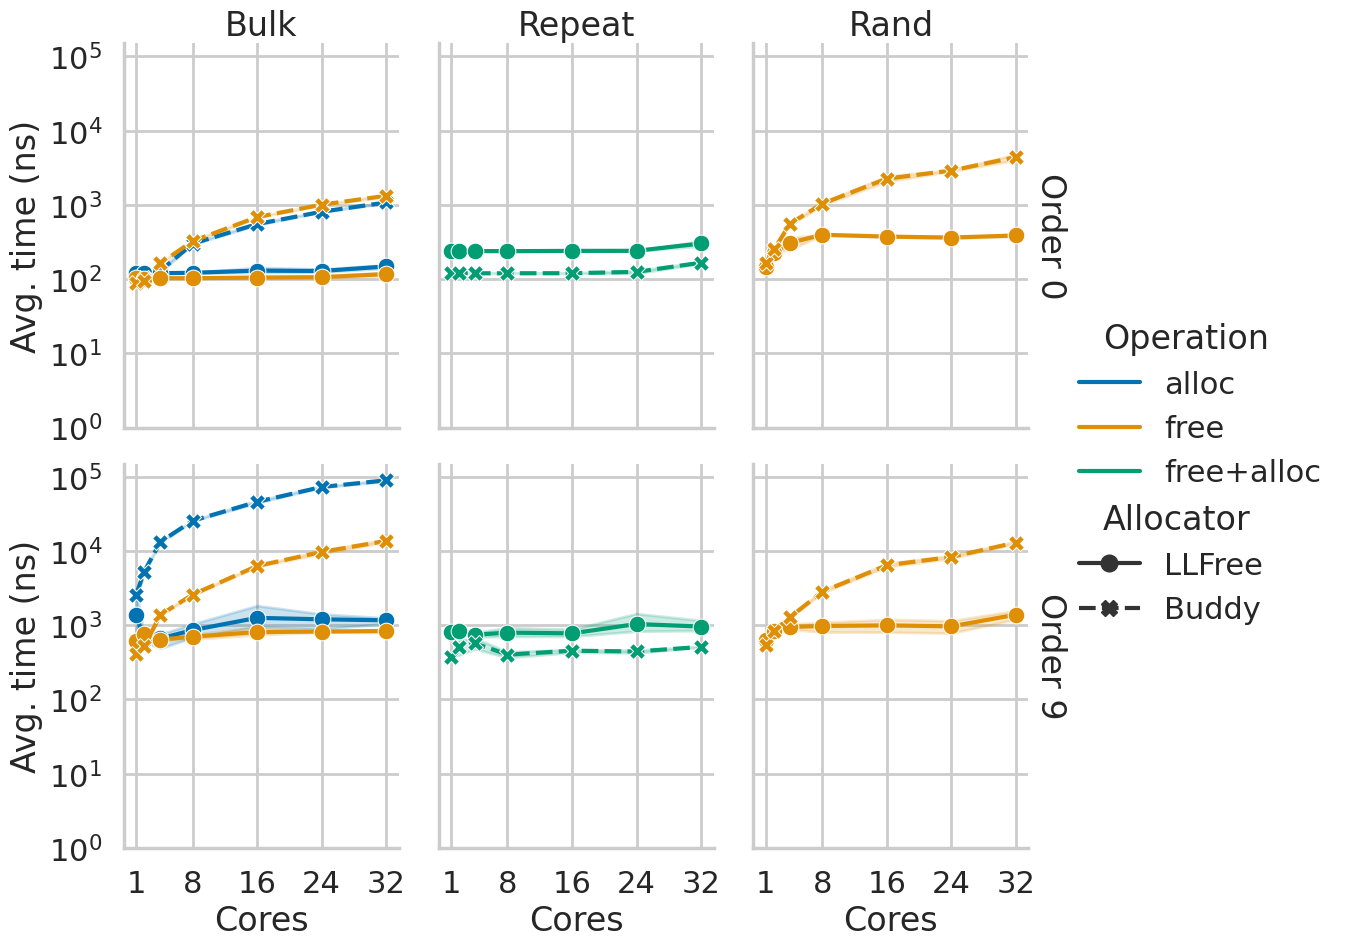

In [10]:

data_c_b = read_allocs(ll_c, bu_c, "bulk", [0, 9])
data_c_b["free+alloc"] = 0
data_c_b["bench"] = "Bulk"
data_c_r = read_allocs(ll_c, bu_c, "repeat", [0, 9])
data_c_r["bench"] = "Repeat"
data_c_r["free+alloc"] = data_c_r["alloc"]
data_c_r["alloc"] = 0
data_c_r["free"] = 0
data_c_a = read_allocs(ll_c, bu_c, "rand", [0, 9])
data_c_a["free+alloc"] = 0
data_c_a["bench"] = "Rand"
data_c_a["alloc"] = 0

data_o = pd.concat([data_c_b, data_c_r, data_c_a])
pgd = data_o.melt(
    id_vars=["bench", "order", "cores", "Allocator"],
    value_vars=["alloc", "free", "free+alloc"], value_name="time", var_name="Operation")

with sns.plotting_context("poster"):
    g = sns.FacetGrid(data=pgd, row="order", col="bench",
                      height=5, aspect=0.8, margin_titles=True, )
    g.map_dataframe(sns.lineplot, x="cores", y="time", markers=True,
          style="Allocator", hue="Operation")
    g.add_legend(adjust_subtitles=True)
    g.set(xticks=[1, 8, 16, 24, 32])
    g.set(ylim=(1, 10**5 * 1.5))
    g.set(yscale="log")
    g.set(ylabel="Avg. time (ns)")
    g.set(xlabel="Cores")
    g.set_titles(col_template="{col_name}", row_template="Order {row_name}")
    g.savefig("out/module_c.pdf")
